# 개요
* GPT활용교육을 들은 내용을 별도로 정리
  * 1일차 : 네이버API 활용 : GPT를 활용한 변수 분석 등
  * 2일차 : beautifulsoup활용한 뉴스 및 증권사리포트 크롤링
  * 3일차 : 뉴스 및 증권사리포트 데이터 전처리 
  * 4일차 : 감성점수 변환
  * 5일차 : 백테스팅 실습
* 상위종목추출 & 비중설정 - 리밸런싱 - 평가지표 순으로 진행

# 5일차 실습내용 정리

## 실습 : 상위 20/25%인 종목 추출하기

In [ ]:
# 데이터 불러오기
import pandas as pd

final_news_scores = pd.read_csv('4_3_데이터/final_news_scores.csv')
final_reports_scores = pd.read_csv('4_3_데이터/final_reports_scores.csv')

final_news_scores["date"] = pd.to_datetime(final_news_scores["date"])
final_news_scores["month_date"] = final_news_scores["date"].apply(lambda x: x.strftime("%Y-%m"))

final_reports_scores["date"] = pd.to_datetime(final_reports_scores["date"])
final_reports_scores["month_date"] = final_reports_scores["date"].apply(lambda x: x.strftime("%Y-%m"))

* GPT에 데이터프레임명과 아래와 같은 프롬프트, 데이터를 함께 제공
```
퀀트 투자 백테스팅을 위해 종목을 선정하고 포트폴리오의 비중을 결정하는 Python 코드를 작성해 주세요. 이때 사용하는 데이터는 다음과 같이 생겼습니다.
데이터프레임 이름은 final_reports_scores입니다.
```

In [ ]:
final_reports_scores[['company', 'ticker', 'date', 'month_date', 'positive_score', 'negative_score', 'neutral_score']].head(5)

,company,ticker,date,month_date,positive_score,negative_score,neutral_score
0,LG에너지솔루션,373220.KS,2023-01-31,2023-01,0.70,0.15,0.15
1,삼성SDI,006400.KS,2023-01-31,2023-01,0.65,0.15,0.20
2,삼성SDI,006400.KS,2023-01-31,2023-01,0.75,0.10,0.15
3,삼성중공업,010140.KS,2023-01-31,2023-01,0.65,0.25,0.10
4,SGC에너지,005090.KS,2023-01-31,2023-01,0.70,0.10,0.20


* GPT에 아래와 같은 프롬프트를 제공하여 함수 코드 작성
```
주어진 month_date 값을 기준으로 특정 월의 데이터만 필터링한 후, 동일한 company가 여러 개 등장할 경우 positive_score, negative_score, neutral_score의 평균을 계산하여 하나의 데이터로 병합하는 코드를 작성해 주세요.

- 입력값(input)
month_date (예: '2023-01')
상위 몇퍼센트를 사용할 것인지 (예:0.25)
- 처리 과정
month_date 값과 일치하는 데이터만 필터링합니다.
동일한 company(회사명)에 대해 positive_score, negative_score, neutral_score의 평균을 구하여 하나의 레코드로 변환합니다.
- 출력값(output)
가공이 완료된 DataFrame
```

In [ ]:
# 데이터프레임을 넣으면 지정한 상위 %에 해당하는 결과 데이터프레임을 주는 함수 작성
def filter_and_aggregate(final_reports_scores, month_date, selection_ratio=0.25):
    """
    특정 month_date 데이터를 필터링하고, 동일한 company의 점수들을 평균 처리하여 반환.

    Parameters:
    - final_reports_scores (DataFrame): 종목별 점수 데이터
    - month_date (str): 필터링할 월 (예: '2023-01')
    - selection_ratio (float): 상위 몇 % 종목을 선택할 것인지 (기본값 25%)

    Returns:
    - filtered_df (DataFrame): 가공이 완료된 데이터
    """
    # 특정 month_date 값 필터링
    filtered_df = final_reports_scores[final_reports_scores["month_date"] == month_date]

    # 동일한 company에 대해 점수 평균 계산
    aggregated_df = (
        filtered_df.groupby("company", as_index=False)
        .agg({
            "ticker": "first",  # 동일한 회사일 경우 대표 ticker 선택
            "positive_score": "mean",
            "negative_score": "mean",
            "neutral_score": "mean"
        })
    )

    # 상위 selection_ratio 비율 종목 선택 (positive_score 기준)
    top_n = int(len(aggregated_df) * selection_ratio)
    selected_df = aggregated_df.nlargest(top_n, "positive_score")

    return selected_df

In [ ]:
# 예제 실행
month = "2023-01"
selection_ratio = 0.25
processed_data = filter_and_aggregate(final_reports_scores, month, selection_ratio)

In [ ]:
processed_data.head()

,company,ticker,positive_score,negative_score,neutral_score
87,자화전자,033240.KS,0.8500,0.0500,0.100
11,JW중외제약,001060.KS,0.8000,0.0500,0.150
73,아모레G,002790.KS,0.8000,0.0500,0.150
85,이수페타시스,007660.KS,0.7750,0.0500,0.175
15,KT&G,033780.KS,0.7625,0.0625,0.175


In [ ]:
len(processed_data)

33

## 실습 : 종목비중을 설정코드 작성(균등 or 긍정점수 비중에 맞추기)

* GPT에 아래와 같은 프롬프트를 제공하여 함수 코드 작성
```
- 입력값(input)
df: 앞서 선정한 종목들의 DataFrame
method: 비중 결정 방식 ('equal' 또는 'score')
'equal': 모든 종목에 동일한 비중(1/N)을 부여합니다.
'score': positive_score 값을 기준으로 비중을 부여합니다.

- 처리 과정
'equal' 방식: 모든 종목의 비중을 동일하게 설정합니다 (1/N).
'score' 방식: positive_score 값의 총합을 기준으로 각 종목의 비중을 계산합니다.

- 출력값(output)
weight 컬럼이 추가된 DataFrame
```

In [ ]:
# 데이터프레임을 넣으면 지정한 방식(균등equal, score비중 반영)에 맞는 함수 코드
def assign_weights(df, method="equal"):
    """
    선정된 종목들의 포트폴리오 비중을 결정하는 함수.

    Parameters:
    - df (DataFrame): 선정된 종목들의 DataFrame
    - method (str): 비중 결정 방식 ('equal' 또는 'score')

    Returns:
    - df (DataFrame): weight 컬럼이 추가된 DataFrame
    """
    if df.empty:
        print("Error: 입력 데이터가 비어 있습니다.")
        return df

    if method == "equal":
        # 동일한 비중 (1/N)
        df["weight"] = 1 / len(df)

    elif method == "score":
        # positive_score 기준 가중치 계산
        total_score = df["positive_score"].sum()
        if total_score == 0:
            print("Warning: positive_score 총합이 0입니다. 균등 비중을 사용합니다.")
            df["weight"] = 1 / len(df)
        else:
            df["weight"] = df["positive_score"] / total_score

    else:
        raise ValueError("Invalid method. Choose 'equal' or 'score'.")

    return df

In [ ]:
weighted_portfolio = assign_weights(processed_data, method="score")

In [ ]:
weighted_portfolio.head()

,company,ticker,positive_score,negative_score,neutral_score,weight
87,자화전자,033240.KS,0.8500,0.0500,0.100,0.034818
11,JW중외제약,001060.KS,0.8000,0.0500,0.150,0.032770
73,아모레G,002790.KS,0.8000,0.0500,0.150,0.032770
85,이수페타시스,007660.KS,0.7750,0.0500,0.175,0.031746
15,KT&G,033780.KS,0.7625,0.0625,0.175,0.031234


## 실습 : 1달 동안의 수익률을 백테스팅

* 기초개념
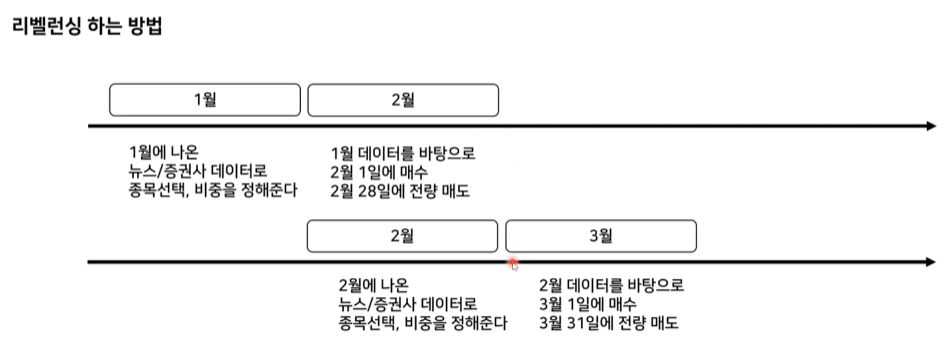
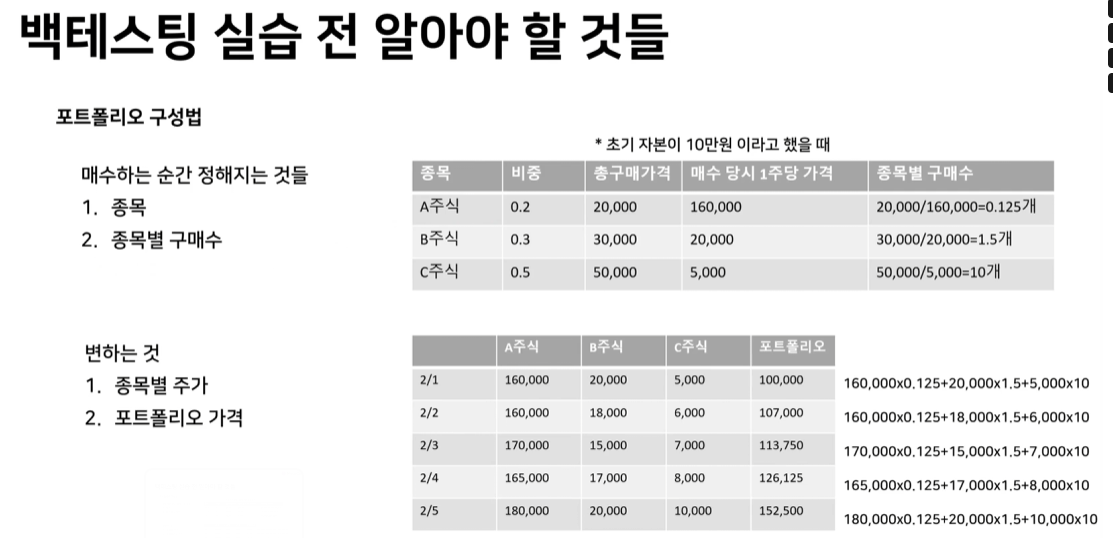

* 백테스팅 가정
  * 주가는 일별 종가 기준으로 산정
  * 매매 수수료 및 세금은 고려하지 않음
  * 소수점 단위 구매가 가능하다는 가정

* GPT에 아래와 같은 프롬프트를 제공하여 함수 코드 작성 (아래 샘플 데이터도 함께 제공)
```
Python을 사용하여 특정 시점에 포트폴리오를 구성하고 한 달 동안의 수익률을 백테스트하는 코드를 작성해 주세요.

요구 사항은 다음과 같습니다.
입력값(input):
- weighted_portfolio: 앞서 처리를 끝낸 DataFrame
company	ticker	positive_score	negative_score	neutral_score	weight
87	자화전자	033240.KS	0.8500	0.0500	0.100	0.034818
11	JW중외제약	001060.KS	0.8000	0.0500	0.150	0.032770
73	아모레G	002790.KS	0.8000	0.0500	0.150	0.032770
- month_date (예: '2023-01')
- invest_amt: 초기 투자 금액 (예:1000)

포트폴리오 구성:
- 선택한 종목들을 month_date의 다음 월에 첫번째 날 (예: 2024-02-01)에 매수합니다.
- 종목별 투자 비율(weight)이 주어지며, 총 투자금(invest_amt)이 정해져 있습니다.

백테스트 진행:
- month_date의 다음 월에 첫번째 날(예:2024-02-01)부터 month_date의 다음 월에 마지막 날(예:2024-02-29)까지 해당 종목의 가격 데이터를 가져옵니다.
- 초기 매수 가격을 기준으로 종목별 매수 가능한 주식 수(shares_held)를 계산합니다.
- 일별 종목 가격 변화에 따라 포트폴리오의 총 가치를 추적합니다.

데이터 소스:
- yfinance 라이브러리를 사용하여 종목별 주가 데이터를 다운로드합니다.

출력:
- 기간 내 일별 포트폴리오 가치 변화를 반환해주세요.
```

In [ ]:
weighted_portfolio.head()

,company,ticker,positive_score,negative_score,neutral_score,weight
87,자화전자,033240.KS,0.8500,0.0500,0.100,0.034818
11,JW중외제약,001060.KS,0.8000,0.0500,0.150,0.032770
73,아모레G,002790.KS,0.8000,0.0500,0.150,0.032770
85,이수페타시스,007660.KS,0.7750,0.0500,0.175,0.031746
15,KT&G,033780.KS,0.7625,0.0625,0.175,0.031234


In [ ]:
# 데이터프레임을 넣으면 앞서 요청한 구성과 백테스팅을 진행하는 코드

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

def backtest_portfolio(weighted_portfolio, month_date, invest_amt=1000):
    """
    특정 시점에서 포트폴리오를 구성하고 한 달 동안 수익률을 백테스트하는 함수.

    Parameters:
    - weighted_portfolio (DataFrame): 선정된 종목과 비중 포함 데이터
    - month_date (str): 포트폴리오 기준 월 (예: '2023-01')
    - invest_amt (float): 초기 투자 금액 (예: 1000)

    Returns:
    - portfolio_value_df (DataFrame): 일별 포트폴리오 가치 변화
    """
    # 투자 시작 날짜 설정 (다음 달 첫 거래일)
    start_date = pd.to_datetime(month_date) + pd.DateOffset(months=1)
    start_date = start_date.replace(day=1)
    end_date = start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)

    # 티커 리스트 가져오기
    tickers = weighted_portfolio["ticker"].unique().tolist()

    # 주가 데이터 다운로드 (시작 날짜부터 한 달간)
    stock_data = yf.download(tickers, start=start_date, end=end_date, progress=False)["Close"]

    # 첫 거래일 가격 (매수 가격) 설정
    buy_prices = stock_data.iloc[0]

    # 종목별 투자 금액 및 매수 주식 수 계산
    weighted_portfolio["invested_amt"] = invest_amt * weighted_portfolio["weight"]
    weighted_portfolio["shares_held"] = weighted_portfolio.apply(lambda row: row["invested_amt"] / buy_prices[row["ticker"]], axis=1)

    # 일별 포트폴리오 가치 계산
    portfolio_values = []
    for date, row in stock_data.iterrows():
        daily_value = (row * weighted_portfolio.set_index("ticker")["shares_held"]).sum()
        portfolio_values.append({"date": date, "portfolio_value": daily_value})

    # 결과 데이터프레임 생성
    portfolio_value_df = pd.DataFrame(portfolio_values)

    return portfolio_value_df


In [ ]:
# 예제 실행

month_date = "2023-01"
invest_amt = 1000
portfolio_result = backtest_portfolio(weighted_portfolio, month_date, invest_amt)

YF.download() has changed argument auto_adjust default to True


In [ ]:
portfolio_result

,date,portfolio_value
0,2023-02-01,1000.000000
1,2023-02-02,1003.766602
2,2023-02-03,1006.418088
3,2023-02-06,1000.696259
4,2023-02-07,1002.741804
5,2023-02-08,1011.224061
6,2023-02-09,1009.665215
7,2023-02-10,1008.266796
8,2023-02-13,1006.485368
9,2023-02-14,1011.019223


## 실습 : 리밸런싱하며 백테스팅

* GPT에 아래와 같은 프롬프트를 제공하여 함수 코드 작성 (아래 샘플 데이터도 함께 제공)
```
Python을 사용하여 특정 시점에 포트폴리오를 구성하고 매달 리밸런싱(rebalancing)하며 백테스트하는 코드를 작성해 주세요.
요구 사항은 다음과 같습니다.

백테스트 개요:
- date 리스트에 주어진 기간(예: ['2023-01', '2023-02', '2023-03']) 동안 매달 리밸런싱을 수행합니다.
- 초기 투자금(init_amt)이 주어집니다.
- 매월 말 포트폴리오의 최종 가치를 계산하고, 다음 달 투자금으로 사용합니다.

종목 선정 및 가중치 할당
- filter_and_aggregate를 사용해서 종목을 선택합니다.
- assign_weights를 사용해서 종목별 비중을 가져옵니다.


백테스트 진행:
- 첫 번째 달에는 init_amt(1,000,000원)으로 포트폴리오를 구성하여 백테스트를 수행합니다.
- 이후 매월 리밸런싱을 수행하며, 이전 달 말의 포트폴리오 가치를 다음 달 투자금으로 사용합니다.
- backtest_portfolio(select_stocks_df, date, invest_amt) 함수를 사용하여 해당 달의 포트폴리오 가치 변화를 계산합니다.
- 모든 기간의 결과를 저장합니다.

출력:
총 포트폴리오 가치 변화를 반환해 주세요.
```

In [ ]:
# 데이터프레임을 넣으면 날짜별로(주어진 기간) 백테스팅하는 코드

import pandas as pd
import yfinance as yf
from datetime import datetime
import time

def rebalancing_backtest(final_reports_scores, dates, init_amt=1000000, selection_ratio=0.25, weight_method="equal"):
    """
    특정 시점에 포트폴리오를 구성하고 매월 리밸런싱하며 백테스트하는 함수.

    Parameters:
    - final_reports_scores (DataFrame): 종목별 점수 포함 데이터
    - dates (list): 백테스트 수행할 월 리스트 (예: ['2023-01', '2023-02', '2023-03'])
    - init_amt (float): 초기 투자금 (기본값: 1,000,000)
    - selection_ratio (float): 종목 선정 비율 (기본값: 25%)
    - weight_method (str): 비중 결정 방식 ('equal' 또는 'score')

    Returns:
    - total_portfolio_values (DataFrame): 기간별 포트폴리오 가치 변화
    """
    portfolio_history = []
    invest_amt = init_amt

    for month_date in dates:
        # 1. 종목 선정 및 가중치 부여
        selected_stocks = filter_and_aggregate(final_reports_scores, month_date, selection_ratio)
        weighted_portfolio = assign_weights(selected_stocks, method=weight_method)

        # 2. 한 달간 백테스트 수행
        time.sleep(30) # 짧은시간에 yfinance를 불러오면 오류가 생길 수 있으므로, 30초 동안 기다려주기
        portfolio_result = backtest_portfolio(weighted_portfolio, month_date, invest_amt)

        # 3. 마지막 날 포트폴리오 가치 추출 (다음 달 투자금으로 설정)
        final_value = portfolio_result.iloc[-1]["portfolio_value"]
        invest_amt = final_value  # 다음 달 투자금으로 사용

        # 4. 결과 저장
        portfolio_result["month_date"] = month_date
        portfolio_history.append(portfolio_result)

    # 전체 결과 합치기
    total_portfolio_values = pd.concat(portfolio_history, ignore_index=True)

    return total_portfolio_values

In [ ]:
# 백테스트 실행

dates = ['2023-01', '2023-02', '2023-03','2023-04', '2023-05', '2023-06']
init_amt = 1000000
selection_ratio = 0.2
weight_method = "score"

total_result = rebalancing_backtest(final_reports_scores, dates, init_amt, selection_ratio, weight_method)

In [ ]:
total_result.head()

,date,portfolio_value,month_date
0,2023-02-01,1.000000e+06,2023-01
1,2023-02-02,1.006297e+06,2023-01
2,2023-02-03,1.011152e+06,2023-01
3,2023-02-06,1.004343e+06,2023-01
4,2023-02-07,1.005958e+06,2023-01


<Axes: xlabel='date'>

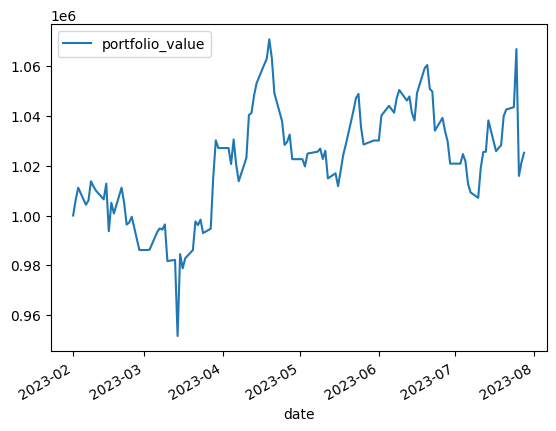

In [ ]:
total_result.plot(x='date', y='portfolio_value')

## 실습 : 평가지표 계산

* GPT에 아래와 같은 프롬프트를 제공하여 함수 코드 작성
```
Python을 사용하여 포트폴리오의 성과 지표를 계산하는 함수를 작성해 주세요.

성과 지표 계산 항목:
- 누적 수익률 (Cumulative Return): 최종 포트폴리오 가치 대비 초기 가치의 증가율을 계산합니다.
- 연평균 수익률 (CAGR, Compound Annual Growth Rate): 전체 기간 동안의 연평균 수익률을 계산합니다.
- 최대 손실폭 (MDD, Maximum Drawdown): 백테스트 기간 동안 포트폴리오의 최대 하락폭을 계산합니다.
- 변동성 (Volatility, 연율화된 표준편차): 일별 수익률의 표준편차를 연율화하여 계산합니다.
- 샤프 비율 (Sharpe Ratio): 위험조정 수익률을 계산합니다. 무위험 이자율(risk_free_rate)은 기본적으로 0.02(연 2%)를 사용합니다.
- 승률 (Win Rate): 총 거래일 중에서 수익이 발생한 날의 비율을 계산합니다.

최종 결과는 각 성과 지표를 포함한 딕셔너리 형태로 반환해 주세요.
```

In [ ]:
# 평가지표 계산 함수

import numpy as np
import pandas as pd

def calculate_performance_metrics(portfolio_df, initial_investment, risk_free_rate=0.02):
    """
    포트폴리오 성과 지표를 계산하는 함수.

    Parameters:
    - portfolio_df (DataFrame): 포트폴리오 가치 변화 데이터 (date, portfolio_value 컬럼 포함)
    - initial_investment (float): 초기 투자금
    - risk_free_rate (float): 무위험 이자율 (기본값: 2% 연율)

    Returns:
    - performance_metrics (dict): 성과 지표를 포함한 딕셔너리
    """

    # 포트폴리오 가치 데이터
    portfolio_values = portfolio_df["portfolio_value"]
    dates = portfolio_df["date"]

    # 일별 수익률 계산
    daily_returns = portfolio_values.pct_change().dropna()

    # 누적 수익률 (Cumulative Return)
    cumulative_return = (portfolio_values.iloc[-1] - initial_investment) / initial_investment

    # 연평균 수익률 (CAGR)
    num_days = (dates.iloc[-1] - dates.iloc[0]).days
    num_years = num_days / 252  # 평균 252거래일 = 1년
    cagr = (portfolio_values.iloc[-1] / initial_investment) ** (1 / num_years) - 1

    # 최대 손실폭 (MDD, Maximum Drawdown)
    cumulative_max = portfolio_values.cummax()
    drawdown = (portfolio_values - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 변동성 (Volatility, 연율화된 표준편차)
    volatility = daily_returns.std() * np.sqrt(252)

    # 샤프 비율 (Sharpe Ratio)
    mean_daily_return = daily_returns.mean()
    sharpe_ratio = ((mean_daily_return - risk_free_rate / 252) / daily_returns.std()) * np.sqrt(252)

    # 승률 (Win Rate)
    win_rate = (daily_returns > 0).sum() / len(daily_returns)

    # 성과 지표 딕셔너리 생성
    performance_metrics = {
        "Cumulative Return": round(cumulative_return, 4),
        "CAGR": round(cagr, 4),
        "Maximum Drawdown": round(max_drawdown, 4),
        "Volatility": round(volatility, 4),
        "Sharpe Ratio": round(sharpe_ratio, 4),
        "Win Rate": round(win_rate, 4),
    }

    return performance_metrics

# 예제 실행
initial_investment = 1000000  # 초기 투자금
performance_metrics = calculate_performance_metrics(total_result, initial_investment)


In [ ]:
# 백테스트 실행 (조건 변경하여 새로 진행)

dates = ['2023-01', '2023-02', '2023-03','2023-04', '2023-05', '2023-06']
init_amt = 1000000
selection_ratio = 0.2
weight_method = "equal"

total_result = rebalancing_backtest(final_reports_scores, dates, init_amt, selection_ratio, weight_method)

In [ ]:
# 평가지표 계산
performance_metrics = calculate_performance_metrics(total_result, initial_investment)
performance_metrics

{'Cumulative Return': np.float64(0.0234),
 'CAGR': np.float64(0.0334),
 'Maximum Drawdown': np.float64(-0.0617),
 'Volatility': np.float64(0.1534),
 'Sharpe Ratio': np.float64(0.2678),
 'Win Rate': np.float64(0.5763)}